Goal: train a logistic regression model for predicting sentiment on food.com reviews. 
We use logistic regression for a binary classification, where negative/neutral comments are encoded as $0$ and positive comments are encoded as $1$. Then we'll use the model to predict sentiments of our embedded tahini data.


Recall that regression algorithms are usually used to predict continuous outcomes, but binary classification is in not continuous. Logisitic regression -- instead of modeling the output class-- cleverly models the probability that a particular data point is an instance of class $1$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gensim
from gensim.models.doc2vec import Doc2Vec

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix #, classification_report
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Will embed each of the comments as a single (300-dimensional) vector using the pretrained doc2vec model and then pass the vectorized review ($X$) with its sentiment $y$ -- where a sentiment is either a 1 or 0. 

In [4]:
# loads the pretrained model
embedding_model = Doc2Vec.load('./text8_doc2vec.model')

In [5]:
%%time
food_dataframe = pd.read_csv("reviews.csv", encoding='utf8')#, low_memory=False)
food_df = food_dataframe.copy()


CPU times: user 8.48 s, sys: 1.56 s, total: 10 s
Wall time: 30.6 s


In [6]:
food_df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [7]:
print("Before any processing, there are", len(food_df), "reviews.")

Before any processing, there are 1401982 reviews.


In [8]:
food_df = food_df[['AuthorId', 'AuthorName', 'Rating', 'Review']]
food_df = food_df[food_df.Rating != 0].reset_index(drop = True)
food_df.dropna(inplace=True)
food_df.head()

,AuthorId,AuthorName,Rating,Review
0,2008,gayg msft,5,better than any you can get at a restaurant!
1,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ..."
2,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...
3,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...
4,2085,Tony Small,5,An excellent dish.


In [9]:
print("There are", len(food_df), "after dropping empty reviews and reviews with no ratings.")

There are 1325520 after dropping empty reviews and reviews with no ratings.


In [10]:
food_df.Rating.unique()

array([5, 4, 2, 1, 3])

In [11]:
# we will attribute a Sentiment 1 if author reported rating of 3 or higher
# and a Sentiment 0 if author reported rating of less than 3
food_df['Sentiment'] = 0
food_df.loc[food_df.Rating >= 3, 'Sentiment'] = 1
food_df.head()

,AuthorId,AuthorName,Rating,Review,Sentiment
0,2008,gayg msft,5,better than any you can get at a restaurant!,1
1,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",1
2,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,0
3,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,1
4,2085,Tony Small,5,An excellent dish.,1


My embedding takes one hundred thousand years on the entire food.com data set, so I'm going to train on a smaller sample until I can figure out how to speed up the process...

In [12]:
#only keep relevant parts of the food_df
df = food_df[['Review','Sentiment']]
df.head()

,Review,Sentiment
0,better than any you can get at a restaurant!,1
1,"I cut back on the mayo, and made up the differ...",1
2,i think i did something wrong because i could ...,0
3,easily the best i have ever had. juicy flavor...,1
4,An excellent dish.,1


In [13]:
# probably can increase the size of this, 
# the embedding took about 2 mins for a sample frac=.02 of the food.com data
df = df.sample(frac=.02, replace=True, random_state=1)
len(df)

26510

In [14]:
%%time
tokenizedReviews = [gensim.utils.simple_preprocess(comment) for comment in df.Review.values]


CPU times: user 2.32 s, sys: 88.3 ms, total: 2.41 s
Wall time: 7.05 s


In [15]:
%%time
embedding_vectors = [embedding_model.infer_vector(tokenized_review) for tokenized_review in tokenizedReviews]


CPU times: user 42.3 s, sys: 1.37 s, total: 43.7 s
Wall time: 2min 8s


In [16]:
df['embeddingVector'] = embedding_vectors
# df.head()

In [17]:
# split the data set into positive and negative reviews
df_positive = df.loc[df['Sentiment']==1]
df_negative = df.loc[df['Sentiment']==0]
print("There are", len(df_positive), "positive reviews and", 
      len(df_negative), "negative reviews in the sample of ", len(df), "reviews.")

There are 25881 positive reviews and 629 negative reviews in the sample of  26510 reviews.


In [18]:
df_validation = pd.concat([df_negative.sample(int(.2*len(df_negative))), df_positive.sample(int(.2*len(df_negative)))])
df_train = df.drop(df_validation.index)

In [19]:
df_train.sample(n=10, random_state=220)

,Review,Sentiment,embeddingVector
660577,I loved these. They were very easy to make an...,1,"[0.080055594, 0.087401494, -0.061562277, -0.01..."
362615,I also found this on the asparagus. It has be...,1,"[0.03789976, 0.026698634, 0.028239977, -0.0480..."
204802,DELICIOUS...The first batch we inhaled as they...,1,"[0.08293277, -0.112285666, 0.22610994, 0.07432..."
1109870,Taste just like the Horchata in my favorite Me...,1,"[0.10577951, 0.060251545, 0.03666158, -0.01374..."
501428,This cheesecake is to die for! I made it toda...,1,"[0.009537853, -0.0145894075, 0.031902023, -0.0..."
280897,Not as spicy as anticipated. Flavor was OK. ...,1,"[0.08075458, 0.039733745, -0.07250014, 0.01516..."
1144601,"Super easy, super quick, super healthy! This t...",1,"[0.03954293, -0.0400705, 0.086222164, -0.02621..."
1129883,"Absolutely SCRUMPTIOUS & EASY; my ""helper"" was...",1,"[-0.026520308, -0.16191365, 0.17572378, -0.159..."
1105881,I made mine in the slow cooker and on the stov...,1,"[-0.15829054, -0.09298427, 0.107586704, 0.0348..."
567826,Mine did not come out like the picture at all....,0,"[0.024720903, 0.00085007015, -0.011291066, -0...."


In [20]:
X_train = np.array(df_train.embeddingVector.values.tolist())
y_train = np.array(df_train.Sentiment.values.tolist())
X_val = np.array(df_validation.embeddingVector.values.tolist())
y_val = np.array(df_validation.Sentiment.values.tolist())

In [21]:
print(X_train.shape)
print(X_val.shape)

(26258, 300)
(250, 300)


In [23]:
print(y_train.shape)
print(y_val.shape)

(26258,)
(250,)


In [24]:
# scale the data to attempt to avoid overfitting
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [25]:
# small value of C for more regularization
log_reg_model = LogisticRegression(solver='liblinear', C=0.05, random_state=0)
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=0.05, random_state=0, solver='liblinear')

In [26]:
## log_reg_model.predict_proba(X) gives a 
## matrix of probabilities that the predicted output given input X 
## is equal to zero (first column) or one (second column)

y_train_pred_probabilities = log_reg_model.predict_proba(X_train)[:,1]
y_val_pred_probabilities = log_reg_model.predict_proba(X_val)[:,1]


In [27]:
## Now plot how the accuracy changes with the cutoff
cutoffs = np.arange(0,1.01,.01)
#https://stackoverflow.com/questions/31488517/getting-the-maximum-accuracy-for-a-binary-probabilistic-classifier-in-scikit-lea
training_accuracy_scores = []
accuracy_scores = []

for cutoff in cutoffs:
    training_accuracy_scores.append(accuracy_score(y_train, [m > cutoff for m in y_train_pred_probabilities]))
    accuracy_scores.append(accuracy_score(y_val, [m > cutoff for m in y_val_pred_probabilities]))

training_accuracies = np.array(training_accuracy_scores)
# max_training_accuracy = training_accuracies.max() 
# max_training_accuracy_cutoff =  cutoffs[training_accuracies.argmax()]

accuracies = np.array(accuracy_scores)
# max_accuracy = accuracies.max() 
# max_accuracy_cutoff =  cutoffs[accuracies.argmax()]


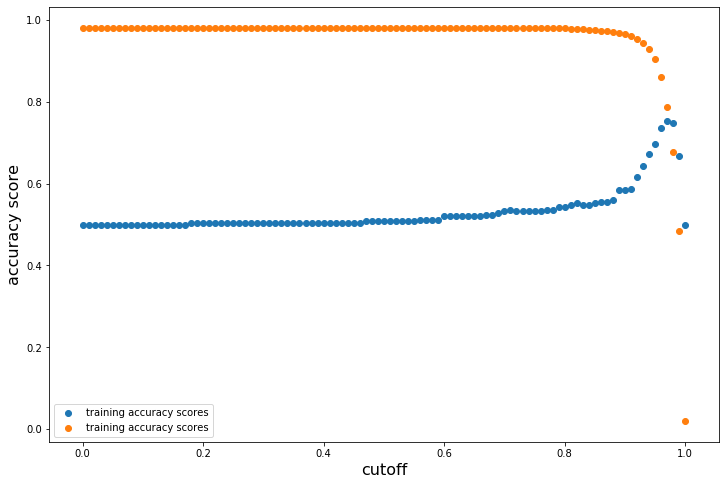

In [28]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs, accuracies, label='training accuracy scores')
plt.scatter(cutoffs, training_accuracies, label='training accuracy scores')

plt.xlabel("cutoff",fontsize=16)
plt.ylabel("accuracy score",fontsize=16)

plt.legend()
plt.show()

In [30]:
c = 0.96
y_train_pred = 1*(y_train_pred_probabilities > c)
y_val_pred = 1*(y_val_pred_probabilities > c)
print("Let's go with a cutoff of", c)
print("The accuracy on the training set is", accuracy_score(y_train_pred, y_train))
print("The accuracy on the validation set is", accuracy_score(y_val_pred, y_val))

Let's go with a cutoff of 0.96
The accuracy on the training set is 0.8605758245106253
The accuracy on the validation set is 0.736


Now we'll use this model, fitted to the food.com data, with the chosen cutoff of 0.96 (for determining class 1) to predict the sentiment classes for the tahini data.

In [32]:
tahini_dataframe = pd.read_csv("salted-tahini-chocolate-chip-cookies-with-sentiment.csv")
tahini_df = tahini_dataframe.copy()
tahini_df.head()

,user,comment,sentiment
0,lmk,Yum. These took much longer than 16 minutes t...,pos
1,Sonya,If you follow the recipe as written the tahini...,pos
2,KV,I have made these cookies 5 times. My advice i...,pos
3,MaryN,I liked this- the tahini is slightly more subt...,pos
4,Maggie B,Used Shaila M's tweaks. Baked first tray strai...,pos


In [33]:
tahini_df['sentiment_class'] = 0
tahini_df.loc[tahini_df['sentiment']=='pos', 'sentiment_class'] = 1
tahini_df.head()

,user,comment,sentiment,sentiment_class
0,lmk,Yum. These took much longer than 16 minutes t...,pos,1
1,Sonya,If you follow the recipe as written the tahini...,pos,1
2,KV,I have made these cookies 5 times. My advice i...,pos,1
3,MaryN,I liked this- the tahini is slightly more subt...,pos,1
4,Maggie B,Used Shaila M's tweaks. Baked first tray strai...,pos,1


In [34]:
%%time
tokenizedComments = [gensim.utils.simple_preprocess(comment) for comment in tahini_df.comment.values]
tahini_df['tokenizedComments'] = tokenizedComments

CPU times: user 26.2 ms, sys: 2.84 ms, total: 29.1 ms
Wall time: 32.6 ms


In [35]:
%%time
embedding_vectors = [embedding_model.infer_vector(tokenized_comment) for tokenized_comment in tokenizedComments]
tahini_df['embeddingVector'] = embedding_vectors

CPU times: user 594 ms, sys: 30.7 ms, total: 625 ms
Wall time: 1.82 s


In [36]:
tahini_df.head()

,user,comment,sentiment,sentiment_class,tokenizedComments,embeddingVector
0,lmk,Yum. These took much longer than 16 minutes t...,pos,1,"[yum, these, took, much, longer, than, minutes...","[0.02246035, 0.03404442, 0.103791595, 0.005089..."
1,Sonya,If you follow the recipe as written the tahini...,pos,1,"[if, you, follow, the, recipe, as, written, th...","[0.044857815, -0.04239704, 0.06639645, 0.01923..."
2,KV,I have made these cookies 5 times. My advice i...,pos,1,"[have, made, these, cookies, times, my, advice...","[0.02551145, -0.03125408, 0.19305754, 0.092908..."
3,MaryN,I liked this- the tahini is slightly more subt...,pos,1,"[liked, this, the, tahini, is, slightly, more,...","[0.06126368, 0.03790687, 0.0713243, -0.0389027..."
4,Maggie B,Used Shaila M's tweaks. Baked first tray strai...,pos,1,"[used, shaila, tweaks, baked, first, tray, str...","[0.013158846, 0.0029428252, 0.010071039, 0.044..."


In [37]:
X_test = np.array(tahini_df.embeddingVector.values.tolist())
y_test = np.array(tahini_df.sentiment_class.values.tolist())

In [38]:
X_test = scaler.transform(X_test)

In [39]:
y_tahini_pred_probabilities = log_reg_model.predict_proba(X_test)[:,1]

y_tahini_predicted = 1*(y_tahini_pred_probabilities > c)

In [40]:
accuracy_score(y_test, y_tahini_predicted)

0.647887323943662